<a href="https://colab.research.google.com/github/KonstantinMarkyon/practicum_data_example_repo/blob/master/analysis_of_the_behavior_of_users_of_the_mobile_app_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Анализ поведения пользователей мобильного приложения"

Наша цель: выяснить, как ведут себя пользователи мобильного приложения после смены шрифтов. Для достижения этой цели выполним следующие задачи:
- Осуществим предобработку данных;
- Изучим имеющиеся данные;
- Изучим воронку событий;
- Изучим результаты эксперимента.

## Предобработка данных

Импортируем нужные нам библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
import warnings
warnings.filterwarnings("ignore")

Импортируем датасет.

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
201722,MainScreenAppear,8079977679659095142,1565106470,246
73621,OffersScreenAppear,5377830222122315337,1564779920,248
206314,PaymentScreenSuccessful,1877880950237790633,1565113011,246
121542,PaymentScreenSuccessful,4383123329905242808,1564918646,247
93176,CartScreenAppear,1046044714483470353,1564839162,248


Переименуем названия столбцов.

In [ ]:
data = data.rename(columns = {'EventName': 'event_name', 
                              'DeviceIDHash': 'user_id', 
                              'EventTimestamp': 'event_time', 
                              'ExpId': 'group'})

Т.к. в столбце *event_time* выставлено unix-время, преобразуем столбец *event_time* в тип datetime с параметром *unit='s'*.

In [ ]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


Проверим датасет на пропуски.

In [ ]:
data.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
dtype: int64

Проверим на дубликаты.

In [ ]:
data.duplicated().sum()

413

Удалим дубликаты.

In [ ]:
data = data.drop_duplicates()

Создадим столбцы даты.


In [ ]:
data['date'] = pd.to_datetime(data['event_time'].dt.date).dt.strftime('%Y-%m-%d')
data

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


## Анализ датасета

### Сколько всего событий в логе?

In [ ]:
print('Всего в логе {} событий.'.format(data['user_id'].count()))

Всего в логе 243713 событий.


### Сколько всего пользователей в логе?

In [ ]:
print('Всего в логе {} пользователей.'.format(data['user_id'].nunique()))

Всего в логе 7551 пользователей.


### Сколько в среднем событий приходится на пользователя?

In [ ]:
print('Всего в логе {} событий приходится в среднем на каждого пользователя.'.format(int(data.groupby('user_id')['event_name'].count().mean())))

Всего в логе 32 событий приходится в среднем на каждого пользователя.


### Выясним, данными за какой период мы располагаем.

In [ ]:
print('Мы распологаем данными за период с {} по {}.'.format(data['date'].min(), data['date'].max()))

Мы распологаем данными за период с 2019-07-25 по 2019-08-07.


Построим гистограмму по дате и времени.

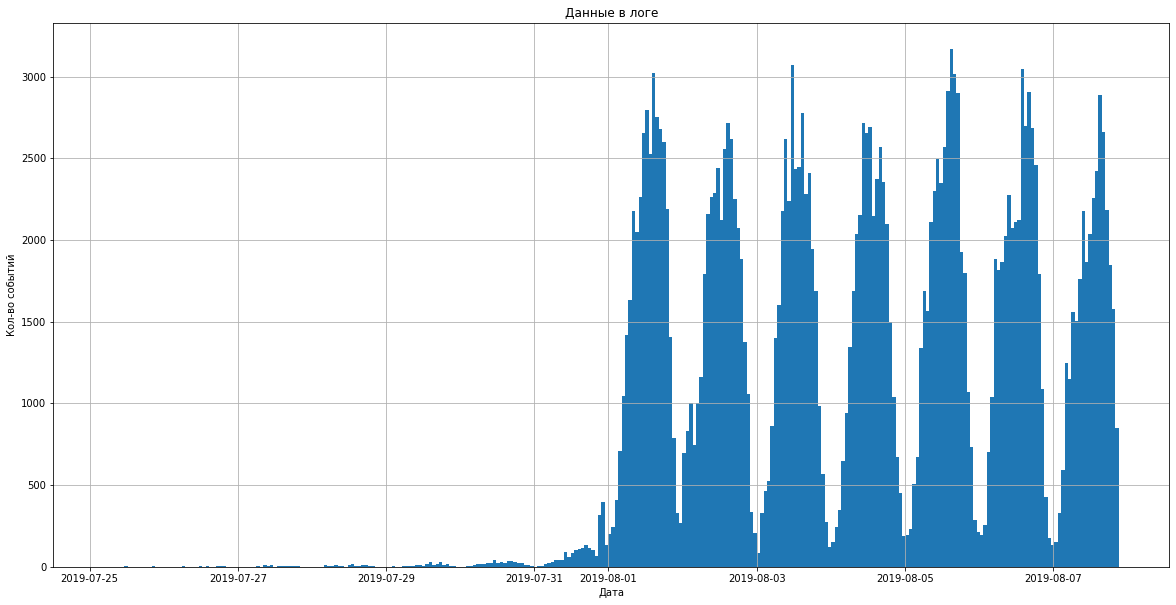

In [ ]:
plt.figure(figsize=(20, 10))
data['event_time'].hist(bins=300)
plt.title('Данные в логе')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.show()

In [ ]:
data.groupby('date').agg({'user_id': 'count'})

,user_id
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


И гистограмма, и сгруппированная таблица показывают, что полные данные начинают появляться с 1 августа. Возьмём этот день за отправную точку. Таким образом, наш период будет отсчитываться с 1 по 7 августа 2019 года. Отбросим старые данные.

In [ ]:
data_new = data[data['date'] > '2019-07-31']
data_new

,event_name,user_id,event_time,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


### Много ли событий и пользователей мы потеряли, отбросив старые данные?

In [ ]:
print('Всего в логе {} событий - на {} событий меньше, чем в изначальном датасете.'
      .format(data_new['user_id'].count(), (data['user_id'].count() - data_new['user_id'].count())))

print('Всего в логе {} пользователей - на {} пользователей меньше, чем в изначальном датасете.'
      .format(data['user_id'].nunique(), (data['user_id'].nunique() - data_new['user_id'].nunique())))

print('Всего в логе {} событий приходится на пользователя.'.format(int(data_new.groupby('user_id')['event_name'].count().mean())))

Всего в логе 240887 событий - на 2826 событий меньше, чем в изначальном датасете.
Всего в логе 7551 пользователей - на 17 пользователей меньше, чем в изначальном датасете.
Всего в логе 31 событий приходится на пользователя.


### Проверим, что у есть пользователи из всех трёх экспериментальных групп.

In [ ]:
data_new['group'].unique()

array([246, 247, 248])

Если есть в датасете все три значения в столбце group, значит, есть и пользователи, к которым они относятся.

## Изучим воронку событий


### Посмотрим, какие события есть в логах, как часто они встречаются.

Осуществим группировку таблицы и построим график-воронку.

In [ ]:
events = data_new.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
events

,event_name,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = events['event_name'],
    x = events['user_id'],
    textinfo = "value+percent initial"))
fig.update_layout(title="Частота событий в логе",
                  yaxis_title="Шаги",)
fig.show()

В логе пять событий. Чаще всего встречается событие *MainScreenAppear* (117328 раз), за ним идёт событие *OffersScreenAppear* (46333 раза), после него *CartScreenAppear* (42303 раза), затем *PaymentScreenSuccessful* (33918 раз) и, наконец, *Tutorial* (всего 1005 раз).

### Посчитаем, сколько пользователей совершали каждое из этих событий. 


In [ ]:
users = data_new.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
users['proportion'] = users['user_id'] / 7551
users

,event_name,user_id,proportion
1,MainScreenAppear,7419,0.982519
2,OffersScreenAppear,4593,0.608264
0,CartScreenAppear,3734,0.494504
3,PaymentScreenSuccessful,3539,0.468680
4,Tutorial,840,0.111244


Мы узнали что за всё время пользователи заходили 7419 раз, из них 4593 сделали следующий шаг и добавили товары в заказ. Затем 3734 человек оформили в корзине заказ и 3539 успешно его оплатили. Заглянули в руководство 840 человек. Построим график-воронку и посмотрим ту же информацию в долях.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = users['event_name'],
    x = users['user_id'],
    textinfo = "value+percent initial"))
fig.update_layout(title="Число пользователей в логе",
                  yaxis_title="Шаги",)
fig.show()

Второй шаг совершило 62% человек из первого шага, 50% - третий шаг, 48% - четвёртый.

Также можно увидеть разницу в долях, воспользовавшись методом pct_change().

In [ ]:
users['user_id'].pct_change().reset_index()

,index,user_id
0,1,NaN
1,2,-0.380914
2,0,-0.187024
3,3,-0.052223
4,4,-0.762645


### В каком порядке происходят события?

С нашей точки зрения, последовательность событий следующая: 1) вначале люди видят страницу с предложениями (*Main*), затем 2) добавляют товар в корзину (*Offers*), после чего 3) переходят в корзину (*Cart*), где 4) оплачивают товары (*Payment*). Инструкция в этой схеме определённо лишняя, потому как очень немногие люди используют её,; большинство справляется без обращения к ней. Иными словами, переход на страницу с инструкцией **не** является обязательным.

In [ ]:
data_new = data[data['event_name'] != 'Tutorial']
data_new['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear'], dtype=object)

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [ ]:
users = data_new.pivot_table(
    index='user_id', columns='event_name', values='event_time', aggfunc='min')

step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_pageview = users[step_1].shape[0]
n_add_to_cart = users[step_2].shape[0]
n_checkout = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('Посетителей:', n_pageview)
print('Добавили товар в корзину:', n_add_to_cart)
print('Начали оформлять заказ:', n_checkout)
print('Оплатили:', n_payment)

Посетителей: 7439
Добавили товар в корзину: 4067
Начали оформлять заказ: 1611
Оплатили: 448


Создадим две переменные: в number будут значения из предыдущего действия (воронка пользователей). В stage положим названия событий. Посмотрим с их помощью график-воронку.

In [ ]:
number = [n_pageview, n_add_to_cart, n_checkout, n_payment]
stage = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = stage,
    x = number,
    textinfo = "value+percent initial"))
fig.update_layout(title="Воронка пользователей",
                  #xaxis_title="x Axis Title",
                  yaxis_title="Шаги",)
fig.show()

Теперь посчитаем то же самое в долях.

In [ ]:
print('Посетителей: 100%')
print('Добавили товар в корзину: {} %'.format(int(n_add_to_cart / n_pageview * 100)))
print('Начали оформлять заказ: {} %'.format(int(n_checkout / n_add_to_cart * 100)))
print('Оплатили: {} %'.format(int(n_payment / n_checkout * 100)))

Посетителей: 100%
Добавили товар в корзину: 54 %
Начали оформлять заказ: 39 %
Оплатили: 27 %


### На каком шаге теряется больше всего пользователей?


Данные говорят, что наибольшая часть пользователей отсекается между первым и вторым шагом., т.е. между заходом в приложение и добавлением товаров в корзину. Может, посетителей не устроили цены? Или есть проблемы с отображением кнопки для добавления в корзину?

### Какая доля пользователей доходит от первого события до оплаты?


In [ ]:
n_payment / n_pageview * 100

6.022314827261729

От первого события до последнего доходит 6% пользователей (что также видно на графике-воронке выше).

## Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [ ]:
groups = ['246', '247', '248']
for i in groups:
    print('В группе "{}" {} пользователей.'.format(i, data_new.query('group == @i')['user_id'].nunique()))

В группе "246" 2488 пользователей.
В группе "247" 2519 пользователей.
В группе "248" 2540 пользователей.


Обращает на себя внимание то, что размеры групп несколько отличаются. Это говорит о неоптимальности разбиения данных по группам. Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Для этого и дальнейших действий напишем функцию, которая будет принимать значения первой и второй групп, а выдавать статистическую разницу по ним по каждому событию.

Гипотезы сформулируем следующим образом: 

- Н0. Не существует статистически значимой разницы между долями; доли статистически равны.
- Н1. Нет оснований считать, что статистически значимая разница между долями отсутствует.


Создадим список, в который положим кол-во уникальных пользователей по каждой группе, а также сразу кол-во по группам 246 и 247 (эти данные понадобятся нам позднее).

In [ ]:
n_users = {'all': data_new['user_id'].nunique(), 
           246: data_new[data_new['group']==246]['user_id'].nunique(),
           247: data_new[data_new['group']==247]['user_id'].nunique(),
           248: data_new[data_new['group']==248]['user_id'].nunique(),
           '246+247': data_new[(data_new['group']==246) | (data_new['group']==247)]['user_id'].nunique()}

Также создадим сводную таблицу с уникальным кол-вом пользователей каждой группы по каждому событию. Она пригодится нам для построения графика и для дальнейших действий.

In [ ]:
group_pivot = data_new.pivot_table(index='event_name',
                                   columns = 'group',
                                   values = 'user_id',
                                   aggfunc = 'nunique').reset_index().sort_values(by=246, ascending=False)
group_pivot

group,event_name,246,247,248
1,MainScreenAppear,2456,2482,2501
2,OffersScreenAppear,1545,1530,1538
0,CartScreenAppear,1270,1240,1239
3,PaymentScreenSuccessful,1202,1160,1185


Функция не только будет считать статистическую разницу, но и строить графики.

In [ ]:
def func(first_group, second_group):
    alpha = 0.05  
    
    purchases = []
    for i in data_new['event_name'].unique():
        purchases = [data_new.query('group == @first_group & event_name == @i')['user_id'].nunique(),
        data_new.query('group == @second_group & event_name == @i')['user_id'].nunique()]
        purchases.append(i)
        
        p1 = purchases[0]/n_users[first_group]
        p2 = purchases[1]/n_users[second_group]
        p_combined = (purchases[0] + purchases[1]) / (n_users[first_group] + n_users[second_group])        
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users[first_group] + 1/n_users[second_group]))
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(i)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('---')
    fig = go.Figure()
    fig.add_trace(go.Funnel(
        name = first_group,
        y = group_pivot['event_name'],
        x = group_pivot[first_group],
        textinfo = "value+percent initial"))
    fig.add_trace(go.Funnel(
        name = second_group,
        y = group_pivot['event_name'],
        x = group_pivot[second_group],
        textinfo = "value+percent initial"))    
    fig.update_layout(title="Группы {} и {}".format(first_group, second_group),
                  #xaxis_title="x Axis Title",
                  yaxis_title="Шаги",)
    fig.show()

Теперь посчитаем разницу между группами 246 и 247.

In [ ]:
func(246, 247)

MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


Как видно, выборки 246 и 247 проходят статистическую проверку, и у нас нет оснований считать доли разными.

### Посчитаем число пользователей, совершивших самое популярное событие в каждой из контрольных групп, а также долю пользователей, совершивших это событие. 

Очевидно, самое популярное событие - MainScreenAppear. Посмотрим число пользователей в уже созданной ранее нами таблице group_pivot, а также построим график, в котором также будут показаны доли.

In [ ]:
group_pivot

group,event_name,246,247,248
1,MainScreenAppear,2456,2482,2501
2,OffersScreenAppear,1545,1530,1538
0,CartScreenAppear,1270,1240,1239
3,PaymentScreenSuccessful,1202,1160,1185


In [ ]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = '246',
    y = group_pivot['event_name'],
    x = group_pivot[246],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = '247',
    y = group_pivot['event_name'],
    x = group_pivot[247],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = '248',
    y = group_pivot['event_name'],
    x = group_pivot[248],
    textinfo = "value+percent initial"))
fig.update_layout(title="Группы 246, 247 и 248",
                  #xaxis_title="x Axis Title",
                  yaxis_title="Шаги",)
fig.show()

Мы уже выяснили ранее, что для обеих контрольных групп все события являются стастически достоверными. Перейдём к следующему пункту.

### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

Воспользуемся функцией:

In [ ]:
func(246, 248)

MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


In [ ]:
func(247, 248)

MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


Для объединённой контрольной группы немного перепишем код функции.

In [ ]:
group_pivot['246+247'] = group_pivot[246] + group_pivot[247]

In [ ]:
    alpha = 0.05  
    
    purchases = []
    for i in data_new['event_name'].unique():
        purchases = [data_new.query('group == 246 & event_name == @i')['user_id'].nunique() + data_new.query('group == 247 & event_name == @i')['user_id'].nunique(),
        data_new.query('group == 248 & event_name == @i')['user_id'].nunique()]
        purchases.append(i)
        leads = [data_new.query('group == 246')['user_id'].nunique() + data_new.query('group == 247')['user_id'].nunique(),
             data_new.query('group == 248')['user_id'].nunique()]

        p1 = purchases[0]/leads[0]
        p2 = purchases[1]/leads[1]
        p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])        
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(i)
        print(purchases)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )
        print('---')

    fig = go.Figure()
    fig.add_trace(go.Funnel(
        name = '246+247',
        y = group_pivot['event_name'],
        x = group_pivot['246+247'],
        textinfo = "value+percent initial"))
    fig.add_trace(go.Funnel(
        name = '248',
        y = group_pivot['event_name'],
        x = group_pivot[248],
        textinfo = "value+percent initial"))
    fig.update_layout(title="Группы 246, 247 и 248",
                 # xaxis_title="x Axis Title",
                  yaxis_title="Шаги",)
    fig.show()

MainScreenAppear
[4938, 2501, 'MainScreenAppear']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
[2362, 1185, 'PaymentScreenSuccessful']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
[2510, 1239, 'CartScreenAppear']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
[3075, 1538, 'OffersScreenAppear']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


Как мы видим, при сравнении объединнённой контрольной группы с тестовой результат тот же - нет оснований считать доли разными.

### Осуществим поправку Бонферрони.

Мы осуществили в общем 16 проверок. Поскольку мы проверяем сразу несколько гипотез, применим поправку Бонферрони

In [ ]:
def func1(first_group, second_group):
    alpha = 0.05/4 
    
    purchases = []
    for i in data_new['event_name'].unique():
        purchases = [data_new.query('group == @first_group & event_name == @i')['user_id'].nunique(),
        data_new.query('group == @second_group & event_name == @i')['user_id'].nunique()]
        purchases.append(i)
        
        p1 = purchases[0]/n_users[first_group]
        p2 = purchases[1]/n_users[second_group]
        p_combined = (purchases[0] + purchases[1]) / (n_users[first_group] + n_users[second_group])        
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users[first_group] + 1/n_users[second_group]))
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(i)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('---')
    fig = go.Figure()
    fig.add_trace(go.Funnel(
        name = first_group,
        y = group_pivot['event_name'],
        x = group_pivot[first_group],
        textinfo = "value+percent initial"))
    fig.add_trace(go.Funnel(
        name = second_group,
        y = group_pivot['event_name'],
        x = group_pivot[second_group],
        textinfo = "value+percent initial"))    
    fig.update_layout(title="Группы {} и {}".format(first_group, second_group),
                  #xaxis_title="x Axis Title",
                  yaxis_title="Шаги",)
    fig.show()

In [ ]:
func(246, 247)

MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


In [ ]:
func(246, 248)

MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


In [ ]:
func(247, 248)

MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


In [ ]:
    alpha = 0.05/4
    
    purchases = []
    for i in data_new['event_name'].unique():
        purchases = [data_new.query('group == 246 & event_name == @i')['user_id'].nunique() + data_new.query('group == 247 & event_name == @i')['user_id'].nunique(),
        data_new.query('group == 248 & event_name == @i')['user_id'].nunique()]
        purchases.append(i)
        leads = [data_new.query('group == 246')['user_id'].nunique() + data_new.query('group == 247')['user_id'].nunique(),
             data_new.query('group == 248')['user_id'].nunique()]

        p1 = purchases[0]/leads[0]
        p2 = purchases[1]/leads[1]
        p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])        
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(i)
        print(purchases)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )
        print('---')

    fig = go.Figure()
    fig.add_trace(go.Funnel(
        name = '246+247',
        y = group_pivot['event_name'],
        x = group_pivot['246+247'],
        textinfo = "value+percent initial"))
    fig.add_trace(go.Funnel(
        name = '248',
        y = group_pivot['event_name'],
        x = group_pivot[248],
        textinfo = "value+percent initial"))
    fig.update_layout(title="Группы 246, 247 и 248",
                 # xaxis_title="x Axis Title",
                  yaxis_title="Шаги",)
    fig.show()

MainScreenAppear
[4938, 2501, 'MainScreenAppear']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
PaymentScreenSuccessful
[2362, 1185, 'PaymentScreenSuccessful']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
CartScreenAppear
[2510, 1239, 'CartScreenAppear']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---
OffersScreenAppear
[3075, 1538, 'OffersScreenAppear']
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---


Даже с поправкой Бонферрони результат остаётся прежним.

## Вывод

Перед нами была поставлена цель проанализировать поведение пользователей приложения по доставке еды. Разработчиков интересовало, не спровоцирует ли изменение шрифта отток пользователей.

После предобработки данных мы выяснили, что всего в логе 243713 событий и 7551 пользователей. Вы выбрали данные с 1 по 7 августа 2019 года, а все данные до этого отсекли из-за их неполноты. Вероятно, неполнота данных связана с постепенным включением новых функций; очевидно, таким образом тестировалась работоспособность новой версии приложения.

Мы выяснили, что в логе пять событий. Чаще всего встречается событие захода в приложение, за ним идёт событие добавления товаров в корзину, после него оформление заказа, затем оплата и, наконец, обращение к инструкции. Вырисовывается чёткая воронка, из которой мы исключаем обращение к инструкции как не необходимый шаг.

Мы выяснили, что большая часть пользователей (чуть меньше половины) "отваливается" после первого шага. Может, посетителей не устроили цены? Или есть проблемы с отображением кнопки для добавления в корзину? От первого до последнего шага доходит всего 6% пользователей - тревожные данные, на которые следует обратить внимание!

Далее мы обратились к А/А/В-тестированию. Мы сформулировали основную гипотезу следующим образом: Не существует статистически значимой разницы между долями; доли статистически равны. Альтернативная гипотеза звучит следующим образом: Нет оснований считать, что статистически значимая разница между долями отсутствует.


Мы создали функцию, проверяющую статистическую разницу между всеми выборками, а затем провели 16 проверок статистических гипотез. Результаты показали, что нет статистически значимой разницы между исследуемых группами. Аналогичный результат был достигнут при применении поправки Бонферрони. Этот результат говорит о том, что **оттока пользователей не случилось**, что в свою очередь означает **успешность проведённых тестов**. Измненение шрифта не повлияло существенным образом на поведение пользователей и, если дизайнеры считают это изменение необходимым, они могут его осуществить.

